In [1]:
from scipy.io import loadmat
import numpy as np
import numpy.ma as ma
import utilities_figures as ufig
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
patient_id = ['ID07', 'ID08', 'ID11', 'ID11']
h_string = ['31to39h', '57to65h', '59to65h', '129to137h']
h_offset = [31, 57, 59, 129]  # hours
h_range = [9, 9, 7, 9]
ylim = [(0, 150), (0, 1500), (0, 1500), (0, 1500)]
t_stamps_0 = [[(32, 10), (35, 10), (38, 15)],
             [(58, 0), (60, 2), (64, 40)],
             [(60, 5), (62, 10), (64, 55)],
             [(129, 45), (133, 36), (136, 30)]]

# Parameters
channel_idx = 0
sw_band = (0.5, 4)
duration = 5  # [min]

data, fs = [], []
nperseg, noverlap = [], []
for i in range(len(patient_id)):
    # Load data
    data_mat = loadmat('../data/' + patient_id[i] + '_' + h_string[i] + '.mat')
    info = loadmat('../data/' + patient_id[i] + '_info.mat')
    fs.append(float(info['fs']))
    data_np = data_mat['EEG']
    data_list = [data_np[j, :] for j in range(data_np.shape[0])]
    data.append(data_list[channel_idx])
    # Make parameters list
    nperseg.append(int(20*fs[i]))
    noverlap.append(int(10*fs[i]))

t_stamps = []
for i, list_val in enumerate(t_stamps_0):
    t_stamps_1 = []
    for j, tuple_val in enumerate(list_val):
        t_stamps_1.append(tuple_val[0] + tuple_val[1]/60)
    t_stamps.append(t_stamps_1)

In [3]:
t_list = []
swa_list = []

for i, sig in enumerate(data):
    # Get spectral density
    f, t, Sxx = signal.spectrogram(sig, fs[i], nperseg=nperseg[i], noverlap=noverlap[i], scaling='density')

    # Extract slow wave band with tukey window
    Sxx_band = Sxx[int(sw_band[0] * Sxx.shape[0] / f[-1]):int(sw_band[1] * Sxx.shape[0] / f[-1]), :]
    tukey_window_band = np.tile(signal.tukey(Sxx_band.shape[0]), (Sxx_band.shape[1], 1)).T
    Sxx_band_tukey = np.multiply(Sxx_band,  tukey_window_band)

    # Compute average band power
    swa = np.mean(Sxx_band_tukey, axis=0)
    
    t_list.append(t)
    swa_list.append(swa)

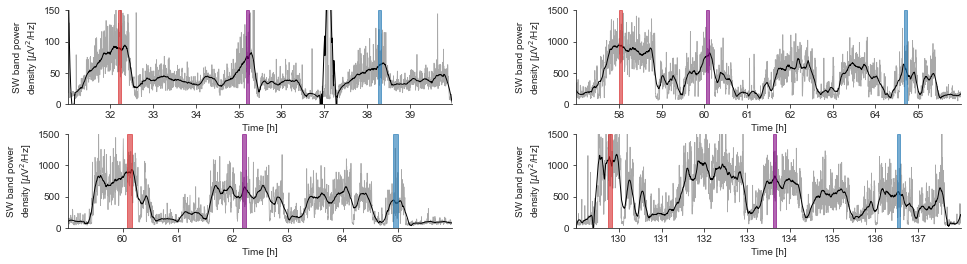

In [5]:
sns.set_style('ticks')
fig = plt.figure(figsize=(16, 4))  # 9, 6
gs = fig.add_gridspec(nrows=23, ncols=23)
ax = [[] for i in range(len(patient_id))]
smooth = []

['tab:red', 'purple', 'tab:blue']

t_hours = []
for i, offset in enumerate(h_offset):
    t_hours.append(t_list[i]/60/60 + offset)

gs_list = [gs[:10, :10], gs[:10, 13:], gs[13:, :10], gs[13:, 13:]]

for i in range(len(patient_id)):
    ax[i] = fig.add_subplot(gs_list[i])
    # Plot raw band
    plt.plot(t_hours[i], swa_list[i], lw=.8, color='darkgrey', label='unfiltered')
    # Plot smooth band
    smooth.append(signal.savgol_filter(swa_list[i], window_length=101, polyorder=3))  # 101, 3
    plt.plot(t_hours[i], smooth[i], c='black', lw=1, label='filtered')
    
    ax[i].set_xlim(t_hours[i][0], t_hours[i][-1])
    if ylim[i] is not None:
        ax[i].set_ylim(ylim[i])
    ax[i].set_ylabel('SW band power\ndensity [$\mu$V$^2$/Hz]')
    ax[i].set_xlabel('Time [h]')
    ax[i].spines['right'].set_visible(False), ax[i].spines['top'].set_visible(False)

    ypos = ax[i].get_ylim()
    colors = ['tab:red', 'purple', 'tab:blue']#['darkred', 'purple', 'mediumblue']
    for j, t_stamp in enumerate(t_stamps[i]):
        ax[i].add_patch(plt.Rectangle((t_stamp, ypos[0]), width=duration/60, height=ypos[1] - ypos[0], zorder=10, edgecolor=colors[j], facecolor=colors[j], alpha=.6))


plt.savefig('figures/fig_Ch2_NREMSelection.png', dpi=400)

In [9]:
swa_list[0].shape

(3239,)

In [18]:
print(t_hours[0].tolist().index(32))
print(t_hours[0].tolist().index(33))

359
719


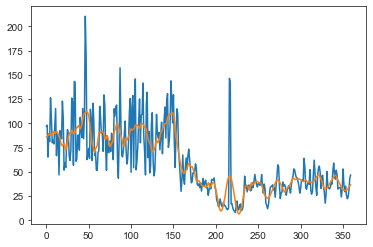

In [28]:
plt.plot(swa_list[0][359:719])
plt.plot(smooth[0][359:719])

np.save('swa.npy', swa_list[0][359:719])
np.save('swa_smooth.npy', smooth[0][359:719])

In [ ]:
smooth[0]